In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pydot
import graphviz
import os
import time
from IPython import display

plt.rcParams['figure.figsize'] = [10, 10]

In [2]:
tf.__version__

'2.0.0'

In [3]:
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.fashion_mnist.load_data()

In [4]:
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = np.pad(train_images, ((0,0),(2,2),(2,2),(0,0)), 'constant')

test_images = test_images.reshape(test_images.shape[0], 28, 28, 1).astype('float32')
test_images = np.pad(test_images, ((0,0),(2,2),(2,2),(0,0)), 'constant')

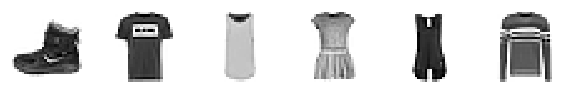

In [5]:
for i in range(6):
    plt.subplot(1, 6, i+1)
    plt.imshow(train_images[i].reshape(32,32),  cmap='Greys')
    plt.axis('off')
plt.show()

np.set_printoptions(precision=3)
np.set_printoptions(suppress=True)

In [6]:
train_noisy_images = train_images.copy()
test_noisy_images = test_images.copy()
# print(type(train_noisy_images[0][0][0][0]))
print(train_images.shape[0])
print(test_images.shape[0])
inp = train_images[0]
re = test_images[0]

# for i in range(0, train_noisy_images.shape[0]):
for i in range(0, train_images.shape[0]):
    mean = 0
    var = 30
    gauss = np.random.normal(mean, var, train_noisy_images[i].shape)
    train_noisy_images[i] += gauss
    train_noisy_images[i] = np.clip(train_noisy_images[i], 0, 255)
    
for i in range(0, test_noisy_images.shape[0]):
    mean = 0
    var = 30
    gauss = np.random.normal(mean, var, test_noisy_images[i].shape)
    test_noisy_images[i] += gauss
    test_noisy_images[i] = np.clip(test_noisy_images[i], 0, 255)

60000
10000


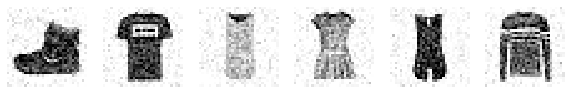

In [7]:
for i in range(6):
    plt.subplot(1, 6, i+1)
    plt.imshow(train_noisy_images[i].reshape(32,32),  cmap='Greys')
#     print(train_images[i])
    plt.axis('off')
plt.show()

In [8]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256
IMG_WIDTH = 32
IMG_HEIGHT = 32

In [9]:
# train_noisy_images = tf.data.Dataset.from_tensor_slices(train_noisy_images)
# type(train_noisy_images)

In [10]:
train_noisy_images = (train_noisy_images - 127.5) / 127.5 # Normalize the images to [-1, 1]
train_images = (train_images - 127.5) / 127.5 # Normalize the images to [-1, 1]

In [11]:
test_images = (test_images - 127.5) / 127.5 # Normalize the images to [-1, 1]
test_noisy_images = (test_noisy_images - 127.5) / 127.5 # Normalize the images to [-1, 1]

In [12]:
# train_noisy_images = tf.data.Dataset.from_tensor_slices(train_noisy_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
train_images = tf.data.Dataset.from_tensor_slices((train_images, train_noisy_images)).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [13]:
# test_noisy_images = tf.data.Dataset.from_tensor_slices(test_noisy_images).batch(BATCH_SIZE)
test_images = tf.data.Dataset.from_tensor_slices((test_images, test_noisy_images)).batch(BATCH_SIZE)

In [14]:
OUTPUT_CHANNELS = 1

In [15]:
def downsample(filters, size, apply_batchnorm=True):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
      tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

  if apply_batchnorm:
    result.add(tf.keras.layers.BatchNormalization())

  result.add(tf.keras.layers.LeakyReLU())

  return result

In [16]:
down_model = downsample(1, 4)
down_result = down_model(tf.expand_dims(inp, 0))
print (down_result.shape)

(1, 16, 16, 1)


In [17]:
def upsample(filters, size, apply_dropout=False):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
    tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                    padding='same',
                                    kernel_initializer=initializer,
                                    use_bias=False))

  result.add(tf.keras.layers.BatchNormalization())

  if apply_dropout:
      result.add(tf.keras.layers.Dropout(0.5))

  result.add(tf.keras.layers.ReLU())

  return result

In [18]:
up_model = upsample(1, 4)
up_result = up_model(down_result)
print (up_result.shape)

(1, 32, 32, 1)


In [19]:
def Generator():
  inputs = tf.keras.layers.Input(shape=[32,32,1])

  down_stack = [
#     downsample(64, 4, apply_batchnorm=False), # (bs, 128, 128, 64)
#     downsample(128, 4), # (bs, 64, 64, 128)
#     downsample(256, 4), # (bs, 32, 32, 256)
    downsample(8, 4, apply_batchnorm=False), # (bs, 16, 16, 512)
    downsample(16, 4), # (bs, 8, 8, 512)
    downsample(32, 4), # (bs, 4, 4, 512)
    downsample(64, 4), # (bs, 2, 2, 512)
    downsample(64, 4), # (bs, 1, 1, 512)
  ]

  up_stack = [
    upsample(64, 4, apply_dropout=True), # (bs, 2, 2, 1024)
    upsample(32, 4, apply_dropout=True), # (bs, 4, 4, 1024)
    upsample(16, 4), # (bs, 8, 8, 1024)
    upsample(8, 4), # (bs, 16, 16, 1024)
#     upsample(256, 4), # (bs, 32, 32, 512)
#     upsample(128, 4), # (bs, 64, 64, 256)
#     upsample(64, 4), # (bs, 128, 128, 128)
  ]

  initializer = tf.random_normal_initializer(0., 0.02)
  last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                         strides=2,
                                         padding='same',
                                         kernel_initializer=initializer,
                                         activation='tanh') # (bs, 256, 256, 3)

  x = inputs

  # Downsampling through the model
  skips = []
  for down in down_stack:
    x = down(x)
    skips.append(x)

  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    x = tf.keras.layers.Concatenate()([x, skip])

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

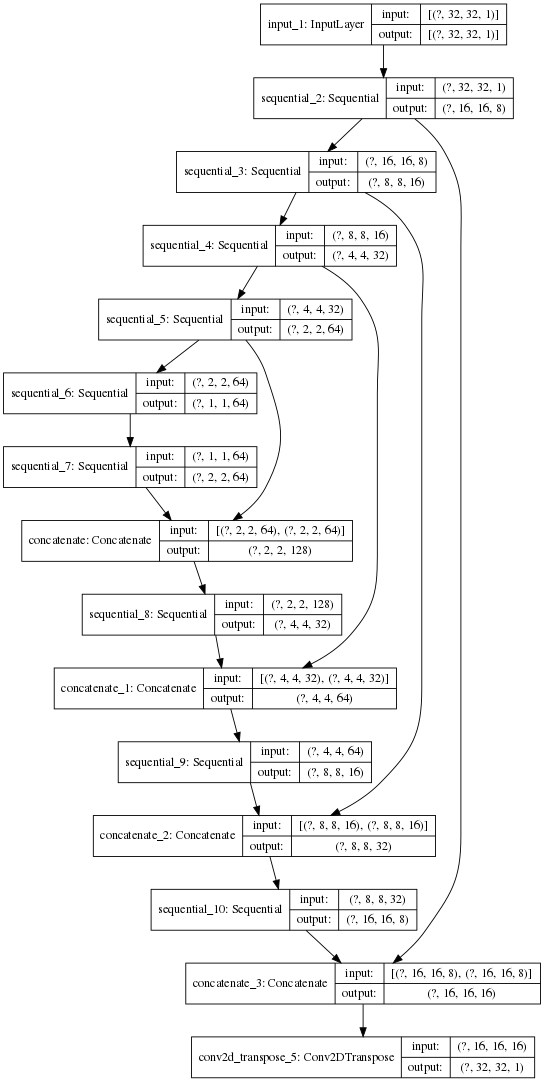

In [20]:
generator = Generator()
tf.keras.utils.plot_model(generator, show_shapes=True, dpi=64)

In [21]:
# gen_output = generator(inp[tf.newaxis,...], training=False)
# plt.imshow(gen_output[0,...])

In [22]:
LAMBDA = 100

In [23]:
def generator_loss(disc_generated_output, gen_output, target):
  gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)

  # mean absolute error
  l1_loss = tf.reduce_mean(tf.abs(target - gen_output))

  total_gen_loss = gan_loss + (LAMBDA * l1_loss)

  return total_gen_loss, gan_loss, l1_loss

In [24]:
def Discriminator():
  initializer = tf.random_normal_initializer(0., 0.02)

  inp = tf.keras.layers.Input(shape=[32, 32, 1], name='input_image')
  tar = tf.keras.layers.Input(shape=[32, 32, 1], name='target_image')

  x = tf.keras.layers.concatenate([inp, tar]) # (bs, 256, 256, channels*2)

  down1 = downsample(8, 4, False)(x) # (bs, 128, 128, 64)
  down2 = downsample(16, 4)(down1) # (bs, 64, 64, 128)
#   down3 = downsample(32, 4)(down2) # (bs, 32, 32, 256)

  zero_pad1 = tf.keras.layers.ZeroPadding2D()(down2) # (bs, 34, 34, 256)
  conv = tf.keras.layers.Conv2D(32, 4, strides=1,
                                kernel_initializer=initializer,
                                use_bias=False)(zero_pad1) # (bs, 31, 31, 512)

  batchnorm1 = tf.keras.layers.BatchNormalization()(conv)

  leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)

  zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu) # (bs, 33, 33, 512)

  last = tf.keras.layers.Conv2D(1, 4, strides=1,
                                kernel_initializer=initializer)(zero_pad2) # (bs, 30, 30, 1)

  return tf.keras.Model(inputs=[inp, tar], outputs=last)

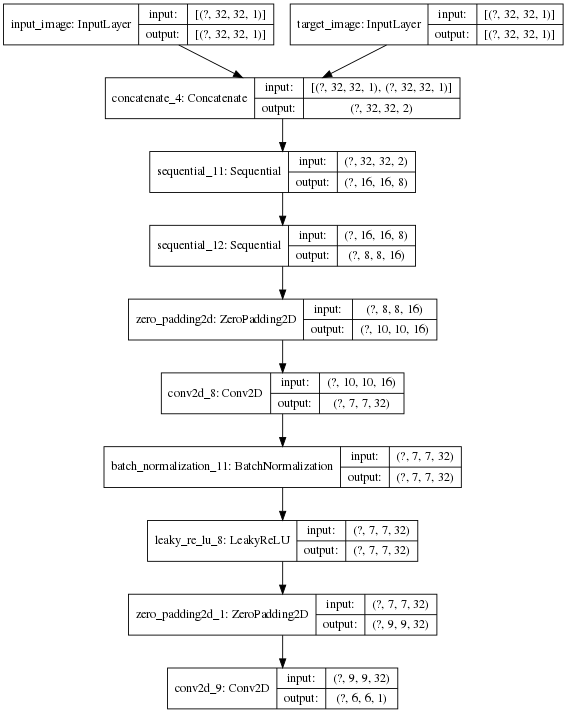

In [25]:
discriminator = Discriminator()
tf.keras.utils.plot_model(discriminator, show_shapes=True, dpi=64)

In [26]:
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [27]:
def discriminator_loss(disc_real_output, disc_generated_output):
  real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)

  generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)

  total_disc_loss = real_loss + generated_loss

  return total_disc_loss

In [28]:
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [29]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [30]:
def generate_images(model, test_input, tar):
  prediction = model(test_input, training=True)
  plt.figure(figsize=(15,15))

  display_list = [test_input[0], tar[0], prediction[0]]
  title = ['Input Image', 'Ground Truth', 'Predicted Image']

  for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.title(title[i])
    # getting the pixel values between [0, 1] to plot it.
    plt.imshow(tf.reshape(display_list[i], (32, 32)) * 0.5 + 0.5, cmap='Greys')
    plt.axis('off')
  plt.show()

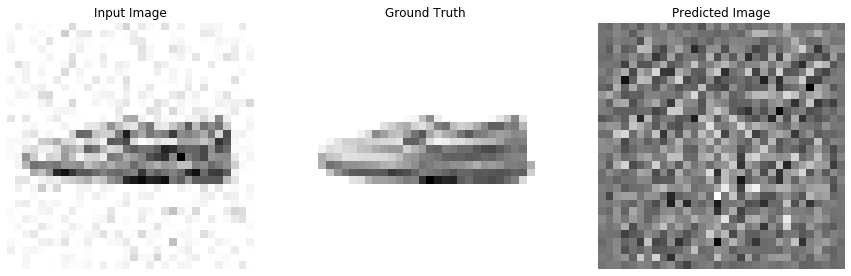

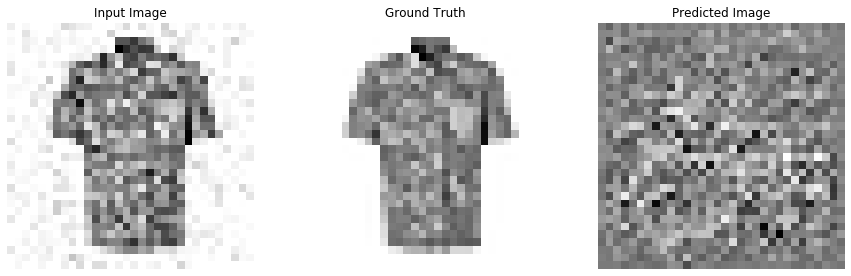

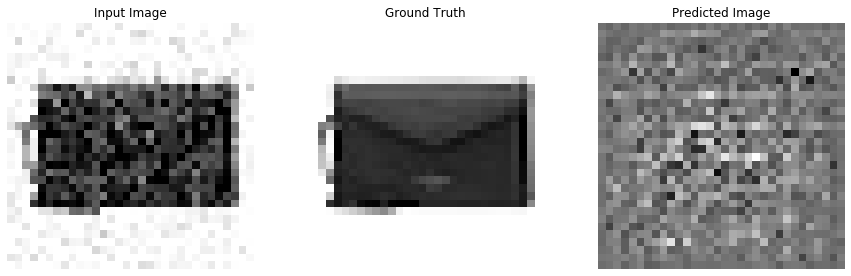

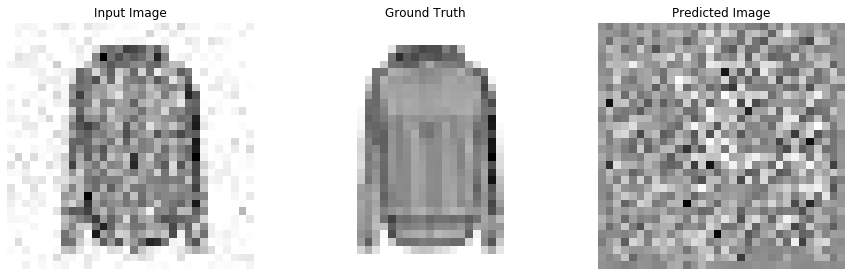

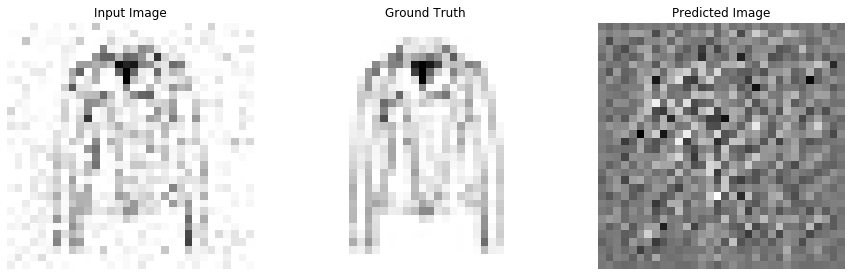

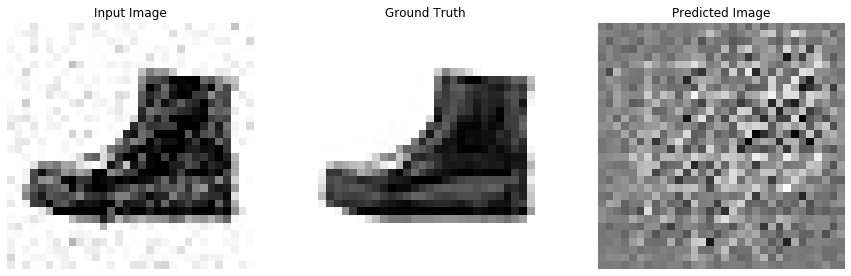

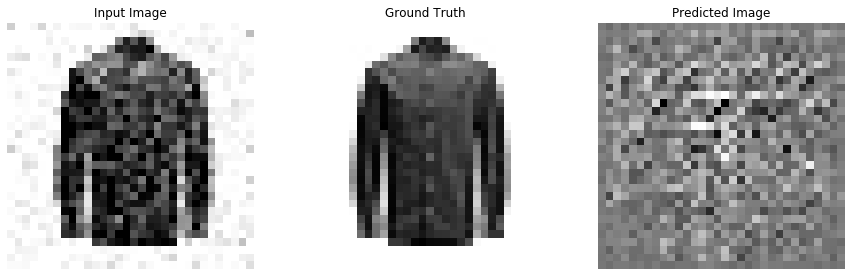

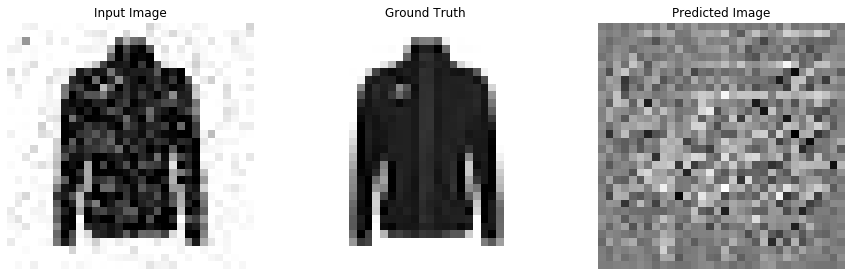

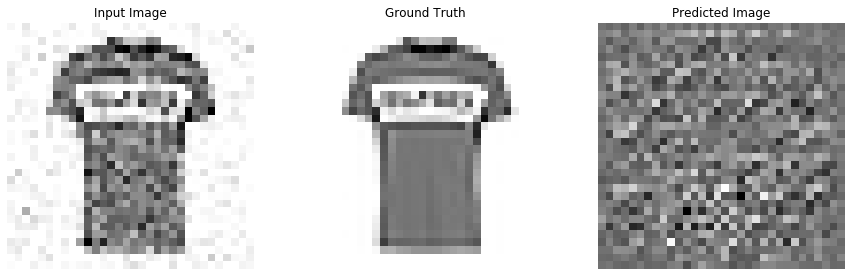

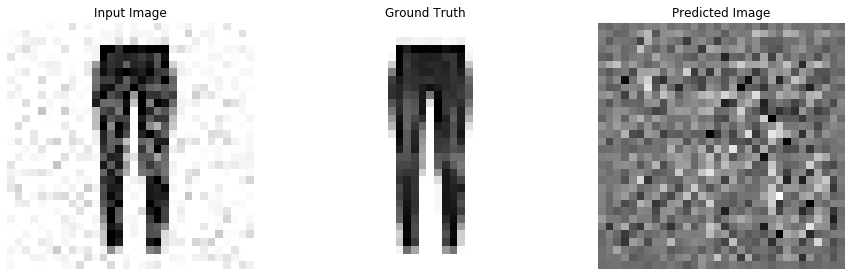

In [31]:
for example_target, example_input in train_images.take(10):
  generate_images(generator, example_input, example_target)

In [32]:
EPOCHS = 150

In [33]:
import datetime
log_dir="logs/"

summary_writer = tf.summary.create_file_writer(
  log_dir + "fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

In [34]:
@tf.function
def train_step(input_image, target, epoch):
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    gen_output = generator(input_image, training=True)

    disc_real_output = discriminator([input_image, target], training=True)
    disc_generated_output = discriminator([input_image, gen_output], training=True)

    gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_generated_output, gen_output, target)
    disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

  generator_gradients = gen_tape.gradient(gen_total_loss,
                                          generator.trainable_variables)
  discriminator_gradients = disc_tape.gradient(disc_loss,
                                               discriminator.trainable_variables)

  generator_optimizer.apply_gradients(zip(generator_gradients,
                                          generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
                                              discriminator.trainable_variables))

  with summary_writer.as_default():
    tf.summary.scalar('gen_total_loss', gen_total_loss, step=epoch)
    tf.summary.scalar('gen_gan_loss', gen_gan_loss, step=epoch)
    tf.summary.scalar('gen_l1_loss', gen_l1_loss, step=epoch)
    tf.summary.scalar('disc_loss', disc_loss, step=epoch)

In [35]:
def fit(train_ds, epochs, test_ds):
  for epoch in range(epochs):
    start = time.time()

    display.clear_output(wait=True)

    for example_target, example_input in test_ds.take(10):
      generate_images(generator, example_input, example_target)
    print("Epoch: ", epoch)

    # Train
    for n, (input_image, target) in train_ds.enumerate():
      print('.', end='')
      if (n+1) % 100 == 0:
        print()
      train_step(input_image, target, epoch)
    print()

    # saving (checkpoint) the model every 20 epochs
    if (epoch + 1) % 20 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time taken for epoch {} is {} sec\n'.format(epoch + 1,
                                                        time.time()-start))
  checkpoint.save(file_prefix = checkpoint_prefix)

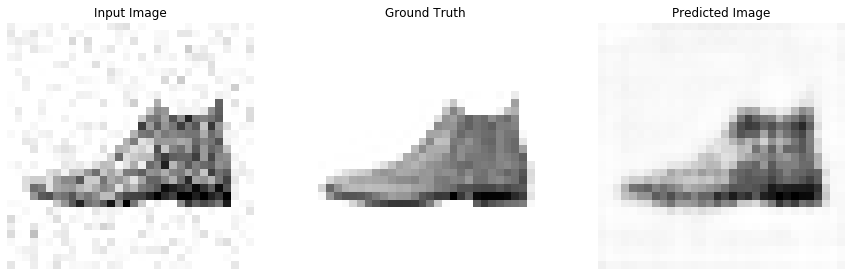

Epoch:  3
.........................................................

In [ ]:
fit(train_images, EPOCHS, test_images)